# BATIQU: Multi-class Batik Classification

Welcome to our notebook for the Batiqu's ML Development! In this notebook, we will get a chance to work on a multi-class classification problem.


---


Here is the table of 20 types of batik patterns/motifs that we will use to create the machine learning model later in this notebook.

| No | Pattern/ Motif Name          | Train Split | Validation Split |
|----|----------------------|-------------|------------|
| 1  | Batik Bali           | 80          | 20         |
| 2  | Batik Betawi         | 80          | 20         |
| 3  | Batik Celup          | 80          | 20         |
| 4  | Batik Cendrawasih    | 80          | 20         |
| 5  | Batik Ceplok         | 80          | 20         |
| 6  | Batik Ciamis         | 80          | 20         |
| 7  | Batik Garutan        | 80          | 20         |
| 8  | Batik Gentongan      | 80          | 20         |
| 9  | Batik Kawung         | 80          | 20         |
| 10 | Batik Keraton        | 80          | 20         |
| 11 | Batik Lasem          | 80          | 20         |
| 12 | Batik Megamendung    | 80          | 20         |
| 13 | Batik Parang         | 80          | 20         |
| 14 | Batik Pekalongan     | 80          | 20         |
| 15 | Batik Priangan       | 80          | 20         |
| 16 | Batik Sekar          | 80          | 20         |
| 17 | Batik Sidoluhur      | 80          | 20         |
| 18 | Batik Sidomukti      | 80          | 20         |
| 19 | Batik Sogan          | 80          | 20         |
| 20 | Batik Tambal         | 80          | 20         |

## The Dataset

Additionally, please note that our dataset is compiled from various sources, including Kaggle, Google Images, research publications, and more.

To access the dataset, you can find the link in [my Google Drive](https://drive.google.com/drive/folders/13JPx25nWzXkrlsYMp3S3kDWityT1CSd1?usp=sharing). However, for privacy and security reasons, **the link is restricted**. If you require access, kindly reach out for authorization.


---

Without further ado, Let's get started! 🔥

## Import All Necessary Libraries
To initiate the model-building process, we need to make sure to import all these following libraries. Remember to execute the cell below to proceed with our work on the model.

In [ ]:
#Import Libraries

import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img
import cv2
from tqdm import tqdm
import os
from random import shuffle
import shutil
from shutil import copyfile
from zipfile import ZipFile
from PIL import Image
import fnmatch
import string

## Load Dataset from Google Drive


Load the dataset with google drive mount:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Splitting the Dataset for Training and Validation
To prepare our dataset for training and validation, follow the steps in the cell below. Execute the code to proceed with this crucial phase of our model development.


In [ ]:
import tensorflow as tf

# Defining the directory for our dataset
dataset_directory = '/content/drive/MyDrive/Dataset_Batik/'

# Using tf.keras.preprocessing.image_dataset_from_directory to load and split the dataset
batch_size = 32
img_height = 224
img_width = 224
validation_split = 0.2
image_shape = (img_height, img_width, 3)

# Creating the training dataset
train_dataset = tf.keras.utils.image_dataset_from_directory(
    dataset_directory,
    validation_split=validation_split,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    labels='inferred'
)

# Creating the validation dataset
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    dataset_directory,
    validation_split=validation_split,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    labels='inferred'
)

# Printing class names
class_names = train_dataset.class_names
print("Class names:", class_names)


Found 2606 files belonging to 20 classes.
Using 2085 files for training.
Found 2606 files belonging to 20 classes.
Using 521 files for validation.
Class names: ['batik-bali', 'batik-betawi', 'batik-celup', 'batik-cendrawasih', 'batik-ceplok', 'batik-ciamis', 'batik-garutan', 'batik-gentongan', 'batik-kawung', 'batik-keraton', 'batik-lasem', 'batik-megamendung', 'batik-parang', 'batik-pekalongan', 'batik-priangan', 'batik-sekar', 'batik-sidoluhur', 'batik-sidomukti', 'batik-sogan', 'batik-tambal']


## Visualizing the Numpy Arrays

Now that we've processed and organized our dataset, let's take a closer look at its structure and characteristics. Execute the code below to visualize key aspects of the dataset and gain insights into its composition.

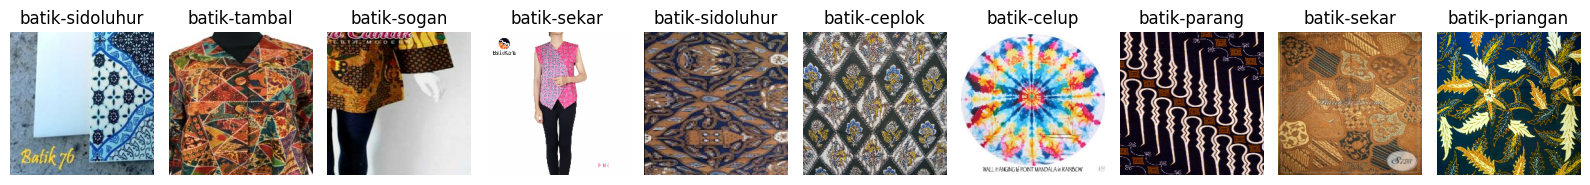

In [ ]:
# Plotting a sample of 10 images from the training set
def plot_categories(train_dataset, class_names):
  fig, axes = plt.subplots(1, 10, figsize=(16, 15))
  axes = axes.flatten()
  letters = list(string.ascii_lowercase)

  for images, labels in train_dataset.take(1):
    for k in range(10):
      img = images[k].numpy()
      img = array_to_img(img)
      ax = axes[k]
      ax.imshow(img, cmap="Greys_r")
      ax.set_title(class_names[int(labels[k])])
      ax.set_axis_off()

  plt.tight_layout()
  plt.show()

plot_categories(train_dataset, class_names)

## Creating the generators for the CNN (& Data Augmentation)

Now that we've efficiently structured the data for compatibility with Keras' ImageDataGenerator, let's proceed to code the generators responsible for producing image batches for both training and validation.

**Additional Note**: Given the limited number of images for each Batik pattern/motif, it is advisable to implement image augmentation techniques to enhance the dataset size. This can include operations such as shearing, rotating, zooming, adjusting brightness, shifting width and height, and flipping. Feel free to fine-tune the parameter values based on your preferences.

**Important!**
Make sure to run this code below

In [ ]:
train_dataset_='/content/drive/MyDrive/Dataset_Batik_Final/train'
validation_dataset_='/content/drive/MyDrive/Dataset_Batik_Final/val'

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tempfile

# Instantiating the ImageDataGenerator class for training

train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    rotation_range=90,
    fill_mode='nearest',
    zoom_range=0.2,
    brightness_range=[0.5, 1.5],
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True
)

validation_datagen = ImageDataGenerator(rescale=1./255)


# Passing in the appropriate arguments to the flow method for training
train_generator = train_datagen.flow_from_directory(
    directory=train_dataset_,
    target_size=(224,224),
    class_mode='categorical',
    batch_size=30,
    color_mode='rgb',
    shuffle=True
)

validation_generator = validation_datagen.flow_from_directory(
    directory=validation_dataset_,
    target_size=(224,224),
    class_mode='categorical',
    batch_size=30,
    color_mode='rgb'
)

class_names =list(train_generator.class_indices.keys())
print(f"Class: {class_names}")

Found 2079 images belonging to 20 classes.
Found 526 images belonging to 20 classes.
Class: ['batik-bali', 'batik-betawi', 'batik-celup', 'batik-cendrawasih', 'batik-ceplok', 'batik-ciamis', 'batik-garutan', 'batik-gentongan', 'batik-kawung', 'batik-keraton', 'batik-lasem', 'batik-megamendung', 'batik-parang', 'batik-pekalongan', 'batik-priangan', 'batik-sekar', 'batik-sidoluhur', 'batik-sidomukti', 'batik-sogan', 'batik-tambal']


## Check Image Validity
This code checks for invalid images in the dataset and alerts if any are found. In case of invalid images, manual importing is recommended to ensure dataset integrity for subsequent model development stages.

In [ ]:
from PIL import Image
import os

def is_valid_image(img_path):
    try:
        img = Image.open(img_path)
        img.verify()  # Verifies the image file's integrity
        return True
    except (IOError, SyntaxError) as e:
        print(f"Invalid image file: {img_path}")
        return False

# Validating images in the training dataset
invalid_images = [img for img in train_generator.filepaths if not is_valid_image(img)]

# Removing invalid images from the dataset
for img_path in invalid_images:
    os.remove(img_path)

# Printing a message if no invalid images are found
if not invalid_images:
    print("There are no invalid images in the dataset!")

There are no invalid images in the dataset!


In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np

img_path = '/content/drive/MyDrive/Dataset_Batik_Final/val/batik-priangan/106.jpg'
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) / 255.0


## Coding the CNN

Here, we code a Convolutional Neural Network (CNN), specialized for image classification. The CNN's architecture includes convolutional layers for feature learning and fully connected layers for classification. This code establishes the foundation for the model to recognize intricate patterns in our Batik pattern/motif dataset.

We are going to use the MobileNetV2 pre-trained model as a feature extractor, benefiting from its pre-trained weights on the ImageNet dataset. Crucially, to utilize the pre-trained model as a feature extractor, it is essential to freeze all layers by setting base_model.trainable = False.

In [ ]:
from tensorflow.keras.applications import MobileNetV2

base_model = MobileNetV2(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3),
    alpha=1.0,
    pooling='avg' # Add GlobalAvgPool2D() layer as its final layer
)

base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_2[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[

**Important!**
Make sure to run this code below

In [ ]:
base_model.trainable = False

**Coding the CNN:**


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from PIL import Image

#Setting up MyCallback function for accelerated training and analysis process
DESIRED_ACCURACY = 0.85
class myCallback(tf.keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs = {}):
            if logs.get('accuracy') is not None and logs.get('accuracy') > DESIRED_ACCURACY:
              print("\nThe target has been reached, stopping training!")
              self.model.stop_training = True
callbacks = myCallback()

# Creating and compiling our model
def create_model():
  # Defining the model
    model = Sequential()
    model.add(base_model)
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(20, activation='softmax'))

    model.compile(
        optimizer=Adam(learning_rate=0.0001),  # You can adjust the learning rate as needed
        loss='categorical_crossentropy',  # Use categorical_crossentropy for multi-class classification
        metrics=['accuracy']
        )

    return model

In [ ]:
model = create_model()

# Training the model
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=100,
    batch_size=64,
    callbacks=[callbacks]  # Pass the custom callback here
)

Epoch 1/100
70/70 [==============================] - 702s 10s/step - loss: 2.8283 - accuracy: 0.1717 - val_loss: 2.4073 - val_accuracy: 0.2852
Epoch 2/100
70/70 [==============================] - 164s 2s/step - loss: 2.2540 - accuracy: 0.3588 - val_loss: 2.0583 - val_accuracy: 0.4316
Epoch 3/100
70/70 [==============================] - 177s 3s/step - loss: 1.9414 - accuracy: 0.4464 - val_loss: 1.8382 - val_accuracy: 0.4924
Epoch 4/100
70/70 [==============================] - 148s 2s/step - loss: 1.7635 - accuracy: 0.4945 - val_loss: 1.7053 - val_accuracy: 0.5285
Epoch 5/100
70/70 [==============================] - 166s 2s/step - loss: 1.6289 - accuracy: 0.5291 - val_loss: 1.5953 - val_accuracy: 0.5665
Epoch 6/100
70/70 [==============================] - 172s 2s/step - loss: 1.5195 - accuracy: 0.5767 - val_loss: 1.5410 - val_accuracy: 0.5703
Epoch 7/100
70/70 [==============================] - 168s 2s/step - loss: 1.4630 - accuracy: 0.5835 - val_loss: 1.4883 - val_accuracy: 0.6008
Epoch

Now take a look at our training history:

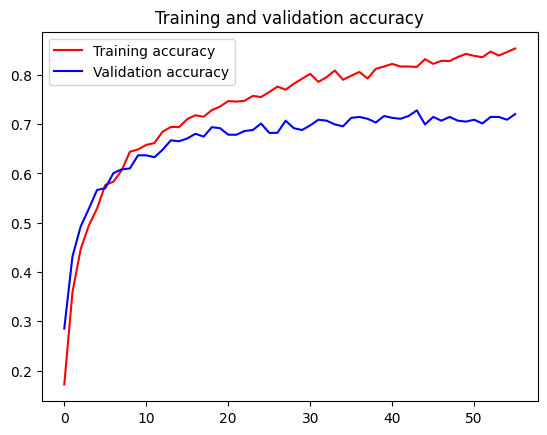

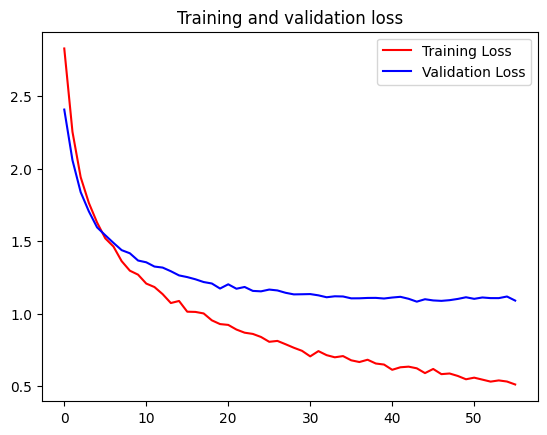

In [ ]:
# Plotting the chart for accuracy and loss on both training and validation for analysis process
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

##Analysis On the Model

As observed in the above graph, we obtain accuracy and loss metrics for both the training and validation sets. The graph suggests that the validation accuracy closely aligns with the training accuracy, indicating that our machine learning model remains **reasonably accurate and, most importantly, does not exhibit signs of overfitting.**

A similar pattern is evident in the training and validation loss, where the gap is minimal, and a decreasing trend is observed. This implies that our machine learning model is reasonably accurate and avoids significant deviations between the training and validation datasets.

---



---



##THE FINAL MODEL

Here is the final model that we will deploy and integrate into our team project application:








In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from PIL import Image

DESIRED_ACCURACY = 0.9

#Setting up MyCallback function for accelerated training and analysis process
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        training_accuracy = logs.get('accuracy')
        validation_accuracy = logs.get('val_accuracy')

        if training_accuracy is not None and validation_accuracy is not None:
            if training_accuracy >= validation_accuracy and training_accuracy > DESIRED_ACCURACY and epoch > 60:
                print("\nThe target has been reached, stopping training!")
                self.model.stop_training = True
callbacks = myCallback()

# Creating and compiling our model
model = Sequential()
model.add(base_model)
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(20, activation='softmax'))

model.compile(
optimizer=Adam(learning_rate=0.0001),
loss='categorical_crossentropy',  # Using categorical_crossentropy for multi-class classification
metrics=['accuracy']
        )


In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 1280)              2257984   
 tional)                                                         
                                                                 
 dense_6 (Dense)             (None, 512)               655872    
                                                                 
 dropout_3 (Dropout)         (None, 512)               0         
                                                                 
 dense_7 (Dense)             (None, 20)                10260     
                                                                 
Total params: 2924116 (11.15 MB)
Trainable params: 666132 (2.54 MB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


In [ ]:
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=100,
    batch_size=64,
    callbacks=[callbacks]
)

Epoch 1/100
70/70 [==============================] - 123s 2s/step - loss: 0.4431 - accuracy: 0.8711 - val_loss: 1.0602 - val_accuracy: 0.7281
Epoch 2/100
70/70 [==============================] - 125s 2s/step - loss: 0.4473 - accuracy: 0.8706 - val_loss: 1.0576 - val_accuracy: 0.7186
Epoch 3/100
70/70 [==============================] - 125s 2s/step - loss: 0.4403 - accuracy: 0.8730 - val_loss: 1.0615 - val_accuracy: 0.7167
Epoch 4/100
70/70 [==============================] - 125s 2s/step - loss: 0.4195 - accuracy: 0.8778 - val_loss: 1.0436 - val_accuracy: 0.7262
Epoch 5/100
70/70 [==============================] - 121s 2s/step - loss: 0.4213 - accuracy: 0.8692 - val_loss: 1.0647 - val_accuracy: 0.7205
Epoch 6/100
70/70 [==============================] - 125s 2s/step - loss: 0.4251 - accuracy: 0.8788 - val_loss: 1.0532 - val_accuracy: 0.7224
Epoch 7/100
70/70 [==============================] - 133s 2s/step - loss: 0.4256 - accuracy: 0.8817 - val_loss: 1.0540 - val_accuracy: 0.7243
Epoch 

## Test The Model
The provided code is designed to test the final machine learning model's performance. It randomly selects 10 classes from the validation dataset, loads a random image from each class, and makes predictions using the trained model.

1/1 [==============================] - 0s 49ms/step


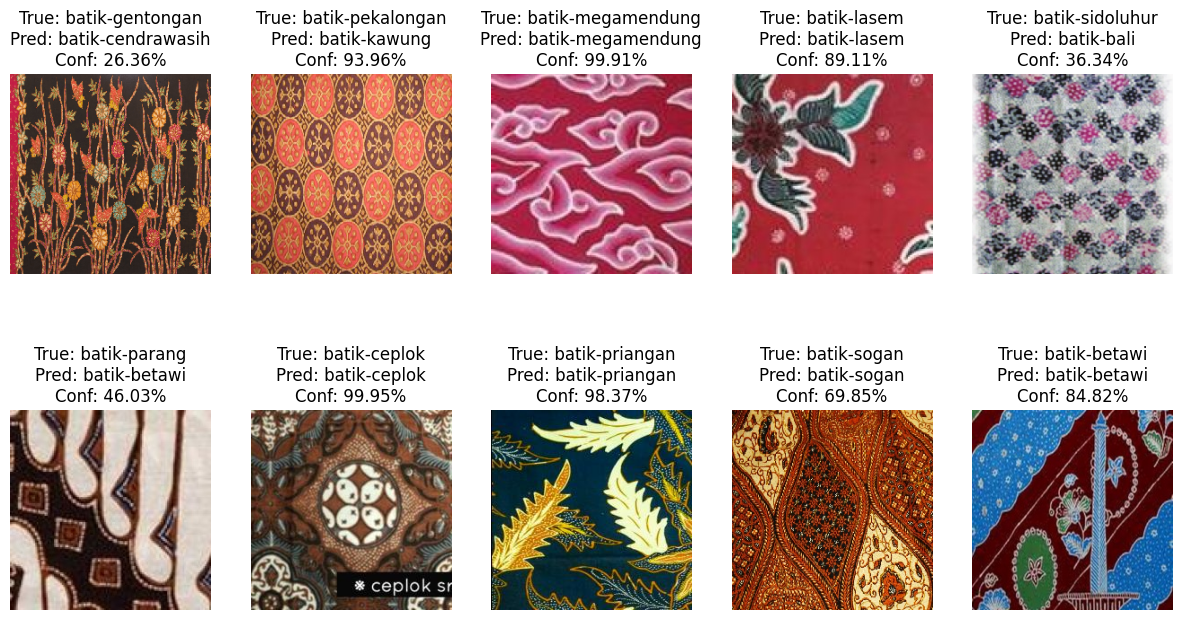

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

# Choosing 10 random classes
random_classes = np.random.choice(class_names, 10, replace=False)

# Setting up subplots for a 2x5 grid
fig, axs = plt.subplots(2, 5, figsize=(15, 8))
fig.subplots_adjust(hspace=0.2)

for i, class_name in enumerate(random_classes):
    class_path = os.path.join(validation_dataset_, class_name)
    img_name = np.random.choice(os.listdir(class_path))
    img_path = os.path.join(class_path, img_name)

    # Loading the image
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0

    # Making prediction
    prediction = model.predict(img_array)
    predicted_class_index = np.argmax(prediction)
    confidence = prediction[0][predicted_class_index]*100

    # Displaying the image and prediction in the subplot
    row = i // 5
    col = i % 5
    axs[row, col].imshow(img)
    axs[row, col].set_title(f"True: {class_name}\nPred: {class_names[predicted_class_index]}\nConf: {confidence:.2f}%")
    axs[row, col].axis('off')

# Showing the grid
plt.show()


## Save The Model and Convert to .tflite and .h5 Format
The last step is to save the model using `tf.saved_model.save()` and convert the saved model into .tflite using `tf.lite.TFLiteConverter.from_saved_model()`and .h5 using 'model.save' method. Once it's done, it's ready to deploy into Batiqu App.

In [ ]:
model_save_path = "saved_model/20_patterns"
tf.saved_model.save(model, model_save_path)

# Convert the model
try:
    converter = tf.lite.TFLiteConverter.from_saved_model(model_save_path)
    tflite_model = converter.convert()

    # Save the model
    os.makedirs('tflite_models', exist_ok=True)
    with open('tflite_models/20_patterns.tflite', 'wb') as f:
        f.write(tflite_model)

    print("Your model successfully saved!")

except Exception as e:
    print("Error in saving the model!")
    print(f"Error details: {e}")

Your model successfully saved!


In [ ]:
# Save the model in HDF5 format
model_save_path_h5 = "saved_model/20_patterns.h5"

try:
    model.save(model_save_path_h5)
    print("Your model successfully saved in HDF5 format!")

except Exception as e:
    print("Error in saving the model to HDF5!")
    print(f"Error details: {e}")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Your model successfully saved in HDF5 format!




---



---


##(*) Additional Analysis On the Model

1/1 [==============================] - 3s 3s/step


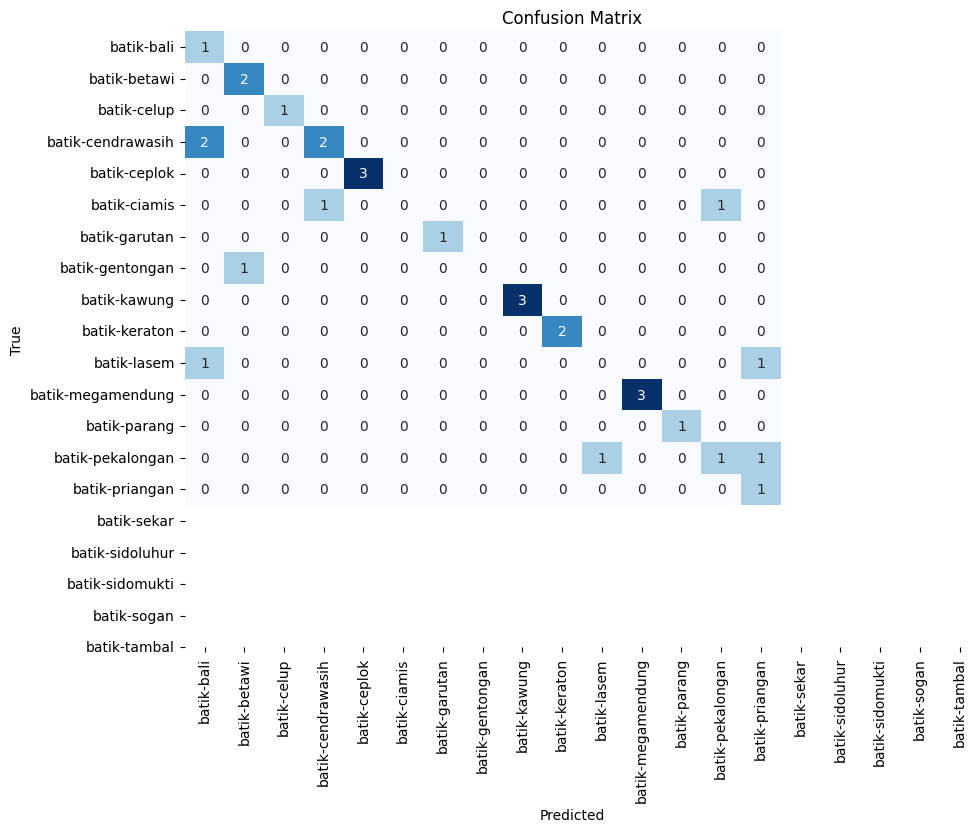

In [ ]:
from tensorflow.keras.models import load_model

# Load the entire model from the H5 file
model = load_model("/content/saved_model/20_patterns.h5")

# Assuming you have a validation dataset
X_val, y_val = validation_generator.next()
y_true = np.argmax(y_val, axis=1)

# Use the loaded model to make predictions
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)

# Create a confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Display the confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()